Using cache found in /home/t/tianqi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-10 Python-3.8.10 torch-1.12.1+cu102 CUDA:0 (NVIDIA TITAN RTX, 24220MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
Using cache found in /home/t/tianqi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-10 Python-3.8.10 torch-1.12.1+cu102 CUDA:0 (NVIDIA TITAN RTX, 24220MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


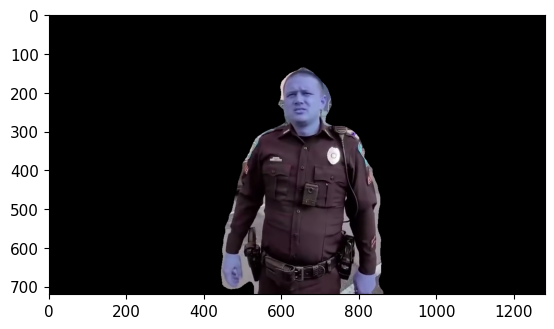

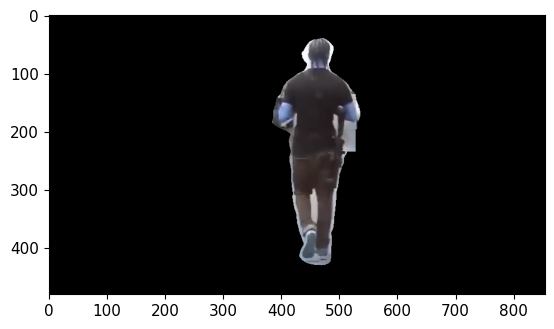

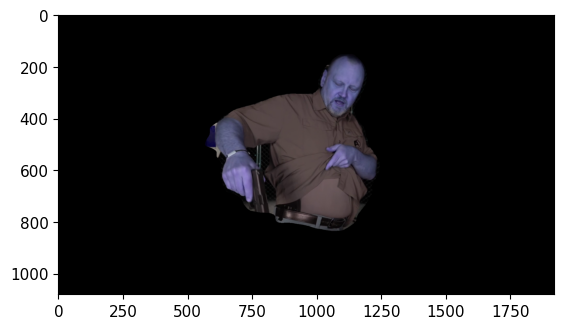

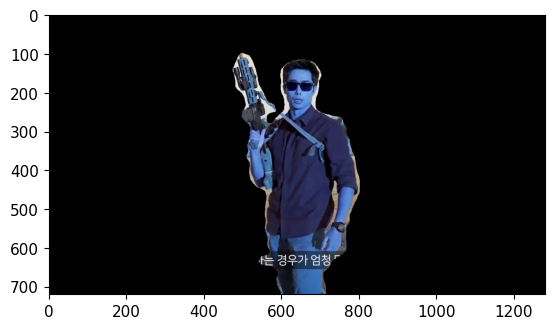

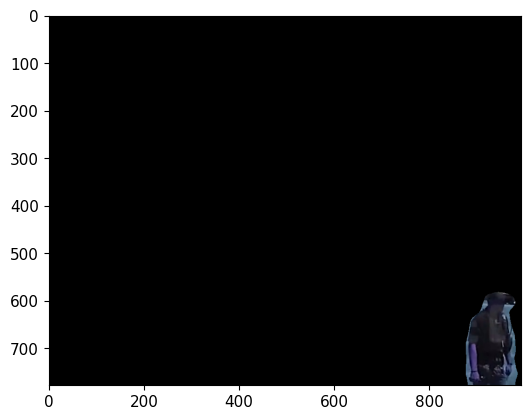

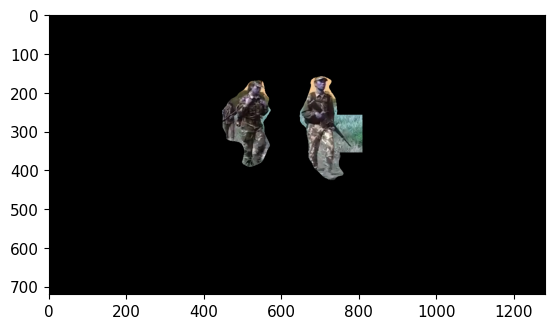

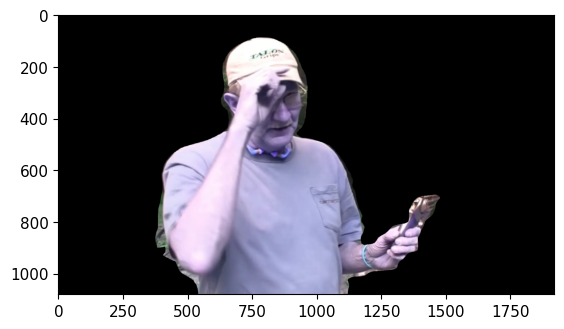

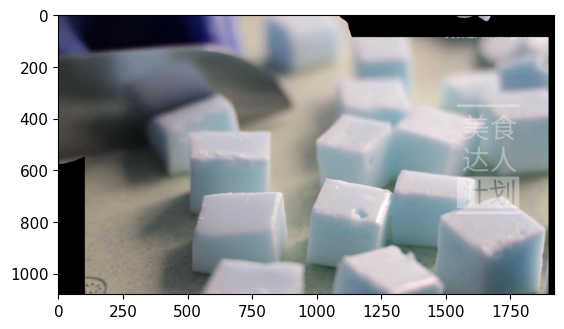

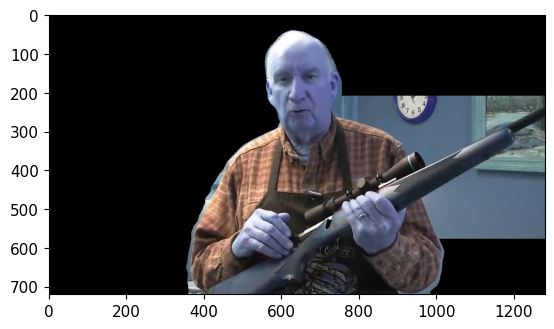

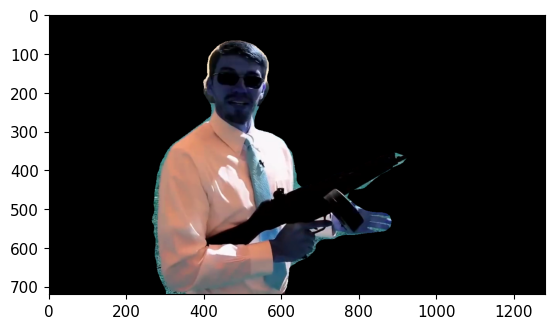

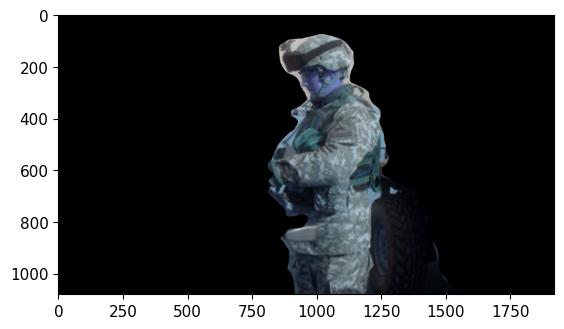

defaultdict(<function <lambda> at 0x7f84ee397d30>, {-1: 8, 1: 3})
defaultdict(<function <lambda> at 0x7f84ee397dc0>, {-1: 6, 1: 5})


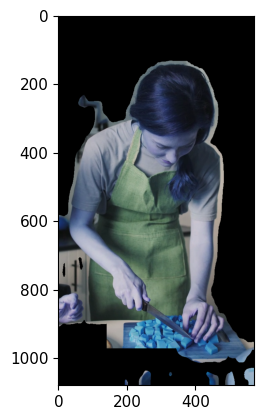

-1

In [2]:
import torch
import os
from collections import defaultdict
import seg
import cv2
import matplotlib.pyplot as plt
import numpy as np
from math import floor

%matplotlib inline

gun_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/home/t/tianqi/CS4243_proj/utils/best_11_09.pt')
gun_model.conf = 0.1
knife_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/home/t/tianqi/CS4243_proj/utils/knife_best.pt')
knife_model.conf = 0.1

def get_classifcation_bounding_box(file_path, model, asize):
    results = model(file_path, size=asize)

    objects = []
    for obj in results.xyxy[0]:
        objects.append(
            {
                "class": int(obj[5]), 
                "xmin": float(obj[0]),
                "ymin": float(obj[1]),
                "xmax": float(obj[2]),
                "ymax": float(obj[3]),
            })
    return objects


def detect_overlap(mask, xmin, xmax, ymin, ymax):
    return np.count_nonzero(mask[ymin:ymax, xmin:xmax]) > 0

def combine_mask_bounding_box(file_path, mask_thres, box_thres):
    gun_boxes = get_classifcation_bounding_box(file_path, gun_model, 540)
    knife_boxes = get_classifcation_bounding_box(file_path, knife_model, 640)

    boxes = gun_boxes + knife_boxes
    mask = seg.get_seg_bin(file_path, thres=mask_thres)
    r, c = mask.shape

    for box in boxes:
        xmin, xmax, ymin, ymax = floor(box["xmin"]), floor(box["xmax"]), floor(box["ymin"]), floor(box["ymax"])
        if detect_overlap(mask, xmin, xmax, ymin, ymax):
            mask[max(0, ymin-box_thres):min(ymax+box_thres, r), max(0, xmin-box_thres):min(xmax+box_thres, c)] = 1
    return mask


def get_classification(file_path, mask_thres=50, box_thres=20):
    '''
    Returns
    -1: None
    0: gun
    1: knife
    '''

    img = cv2.imread(file_path)
    # plt.imshow(img)
    # plt.show()
    mask = combine_mask_bounding_box(file_path, mask_thres, box_thres)
    seg_img = cv2.bitwise_and(img, img, mask = mask)
    plt.imshow(seg_img)
    plt.show()

    gun_results = gun_model(seg_img, size=540)
    knife_results = knife_model(seg_img, size=640)

    if len(gun_results.xyxy[0]) == 0 and len(knife_results.xyxy[0]) == 0:
        return -1
    elif len(knife_results.xyxy[0]) != 0:
        # print(file_path)
        return 1
    else:
        return int(gun_results.xyxy[0][0][5])

def get_classification_raw(file_path):
    '''
    Classification
    -1: None
    0: gun
    1: knife
    '''

    gun_results = gun_model(file_path, size=540)
    knife_results = knife_model(file_path, size=640)

    if len(gun_results.xyxy[0]) == 0 and len(knife_results.xyxy[0]) == 0:
        return -1
    elif len(knife_results.xyxy[0]) != 0:
        # print(file_path)
        return 1
    else:
        return int(gun_results.xyxy[0][0][5])

base_path = '/home/t/tianqi/CS4243_proj/dataset/images/carrying/'
files = os.listdir(base_path)

dic = defaultdict(lambda: 0)
dic1 = defaultdict(lambda: 0)

count = 0
for f in files:
    if count > 10:
        break
    dic[get_classification(base_path + f)] += 1
    dic1[get_classification_raw(base_path + f)] += 1
    count = count + 1

print(dic)
print(dic1)

# get_classification(base_path + files[0])
get_classification("/home/t/tianqi/CS4243_proj/dataset/images/carrying/A0221816L_20220901_carrying_2463_Trim0.046365_200.png", mask_thres=0)